# Toy SEIR model for COVID19 in Australia

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Context/Outline" data-toc-modified-id="Context/Outline-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Context/Outline</a></span></li><li><span><a href="#Python-set-up" data-toc-modified-id="Python-set-up-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Python set up</a></span></li><li><span><a href="#Assumptions---model/set-up" data-toc-modified-id="Assumptions---model/set-up-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Assumptions - model/set-up</a></span></li><li><span><a href="#The-model" data-toc-modified-id="The-model-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>The model</a></span><ul class="toc-item"><li><span><a href="#The-ODE-model" data-toc-modified-id="The-ODE-model-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>The ODE model</a></span></li><li><span><a href="#Starting-points" data-toc-modified-id="Starting-points-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Starting points</a></span></li><li><span><a href="#Use-an-ODE-solver" data-toc-modified-id="Use-an-ODE-solver-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Use an ODE solver</a></span></li><li><span><a href="#Plot-and-describe" data-toc-modified-id="Plot-and-describe-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Plot and describe</a></span></li><li><span><a href="#plot-comparative" data-toc-modified-id="plot-comparative-4.5"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>plot comparative</a></span></li><li><span><a href="#Run-the-model" data-toc-modified-id="Run-the-model-4.6"><span class="toc-item-num">4.6&nbsp;&nbsp;</span>Run the model</a></span></li></ul></li></ul></div>

## Context/Outline

This implements a simple SEIR model, where the population is compartmentalised into four mutually exclusive groups: S=susceptible, E=exposed, I=infected, and R=resistant. It is described by the following set of ordinary differential equations for a population of 1 (ie. we are working in population fractions):

$$\begin{align}
\frac{dS}{dt} & = -\beta SI \\
\frac{dE}{dt} & = \beta SI - \alpha E \\
\frac{dI}{dt} & = \alpha E - \gamma I \\
\frac{dR}{dt} & = \gamma I  \\
\end{align} $$
Where:
$$\begin{align}
\frac{d(S+E+I+R)}{dt} & = 0 \\
S+E+I+R & = 1 \\
\end{align}$$


## Python set up

In [1]:
# imports
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from pathlib import Path
from io import StringIO
import scipy.integrate

#pandas
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

# plotting
plt.style.use('ggplot')

# where to save the plot
CHART_DIRECTORY = '../charts'
Path(CHART_DIRECTORY).mkdir(parents=True, exist_ok=True)
CHART_DIRECTORY += '/!SIR-!ODE-'

## Assumptions - model/set-up

In [2]:
N_DAYS = 500                # days - model period
STEP_SIZE = .01             # fraction of days
H = int(1 / STEP_SIZE)      # steps per day
POPULATION = 25_500_000     # Australian people
r0 = 2.5
e_period = 3                # exposure period - days 
                            # to the point of being infectious,
                            # so less than to the point of having
                            # symptoms
i_period = 8                # infectious period - days


# Other
case_fatality_rate = 0.007  # proportion of those infected;
                            # I have seen estimates between 
                            # 0.66% and 1.44% 

# not used
hospitalisation_period = int(9 * H) # days
hospitalisation_rate = 0.06 # proportion of those infected
                            # hugely age dependent.

## The model

### The ODE model

In [3]:
def SEIR_model(y, t, alpha, beta, gamma):
    s, e, i, r = y
    ds_dt = -beta * s * i
    de_dt = (beta * s * i) - (alpha * e)
    di_dt = (alpha * e) - (gamma * i)
    dr_dt = (gamma * i)
    return ds_dt, de_dt, di_dt, dr_dt

### Starting points

In [4]:
def get_parameters(r0):
    # y - starting points - ensure sum to one
    y = np.zeros(4)
    y[1] = 1000 / POPULATION # e
    y[2] = 1000 / POPULATION # i
    y[3] = 0.0 # r
    y[0] = 1.0 - y[1] - y[2] - y[3] # s

    # t - times slices
    t = np.linspace(0, N_DAYS, N_DAYS*H)

    # parameters
    beta = r0 / i_period
    alpha = 1 / e_period
    gamma = 1 / i_period
    print(f'alpha: {alpha}, beta: {beta}, gamma: {gamma}')

    return y, t, alpha, beta, gamma

### Use an ODE solver

In [5]:
def solve(r0):
    
    y0, t, alpha, beta, gamma = get_parameters(r0)

    solution = scipy.integrate.odeint(SEIR_model, y0,
        t, args=(alpha, beta, gamma))
       
    # put the solution into a DataFrame
    solution = pd.DataFrame(solution, columns = ['susceptible',
            'exposed', 'infectious', 'removed'])
    solution.index = solution.index / H # return index to days

    # calculate deaths
    solution['dead'] = solution['removed'] * case_fatality_rate
    solution['recovered'] = solution['removed'] - solution['dead']
    del solution['removed']

    return solution

### Plot and describe

In [6]:
def plot_solution(solution, r0):
    ax = solution.plot(lw=2)
    t = f'COVID19: toy SEIR ODE solution, $R_0={r0}$'
    ax.set_title(t)
    ax.set_xlabel('Day')
    ax.set_ylabel('Population Proportion')
    fig = ax.figure
    fig.set_size_inches(8, 4)
    fig.tight_layout(pad=1)
    fig.savefig(f'{CHART_DIRECTORY}-{t}.png', dpi=125)
    plt.show()
    plt.close()

    # key results
    print('Susceptible at end: '+
          f'{int(solution.susceptible.iloc[-1]*POPULATION):,} '+
          f'({np.round(solution.susceptible.iloc[-1]*100, 1)}%)')
    print('Recovered at end: '+
          f'{int(solution.recovered.iloc[-1]*POPULATION):,} '+
          f'({np.round(solution.recovered.iloc[-1]*100, 1)}%)')
    print('Dead at end: '+
          f'{int(solution.dead.iloc[-1]*POPULATION):,} '+
          f'({np.round(solution.dead.iloc[-1]*100, 1)}%)')

### plot comparative

In [7]:
def plot_comparative(data, title):

    data = data * POPULATION
    ax = data.plot(lw=2)
    ax.set_title(title)
    ax.set_xlabel('Day')
    ax.set_ylabel('Australian People')
    fig = ax.figure
    fig.set_size_inches(8, 4)
    fig.tight_layout(pad=1)
    fig.savefig(f'{CHART_DIRECTORY}-{title}.png', dpi=125)
    plt.show()
    plt.close()

### Run the model

---------------
alpha: 0.3333333333333333, beta: 0.3125, gamma: 0.125


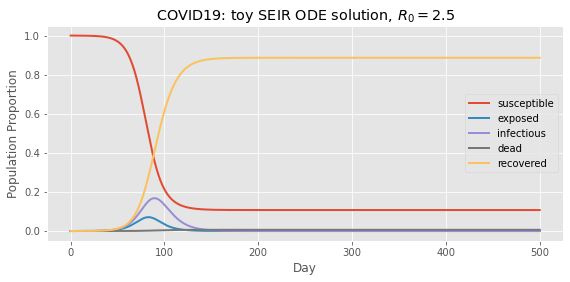

Susceptible at end: 2,737,265 (10.7%)
Recovered at end: 22,603,395 (88.6%)
Dead at end: 159,339 (0.6%)
---------------
alpha: 0.3333333333333333, beta: 0.1875, gamma: 0.125


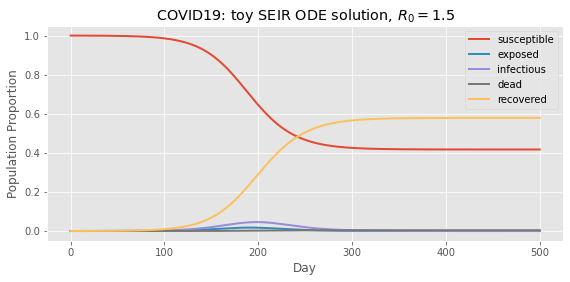

Susceptible at end: 10,636,205 (41.7%)
Recovered at end: 14,759,671 (57.9%)
Dead at end: 104,046 (0.4%)
---------------
alpha: 0.3333333333333333, beta: 0.15, gamma: 0.125


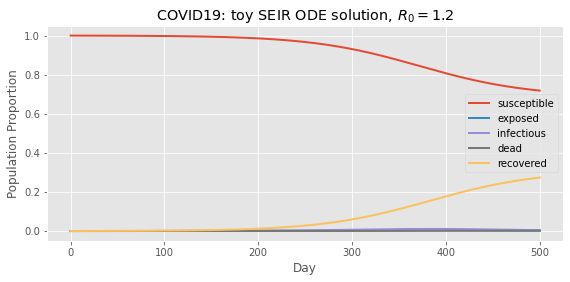

Susceptible at end: 18,319,589 (71.8%)
Recovered at end: 6,976,686 (27.4%)
Dead at end: 49,181 (0.2%)
---------------


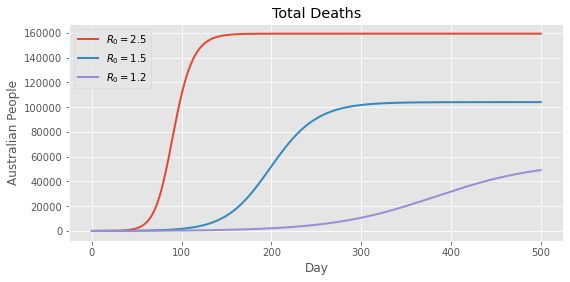

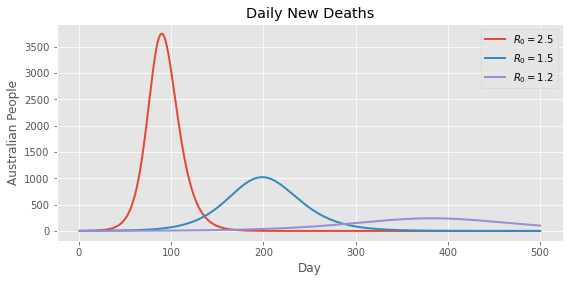

In [8]:
deaths = pd.DataFrame()
for r0 in [2.5, 1.5, 1.2]:
    print ('---------------')
    solution = solve(r0)
    plot_solution(solution, r0)
    deaths[f'$R_0={r0}$'] = solution['dead']

print ('---------------')
plot_comparative(deaths, 'Total Deaths')
plot_comparative(deaths.diff(H), 'Daily New Deaths')

The End